# TP 2

#### Grupo 4: Aschieri Juan Pablo, Civini Diego Emanuel, Rivero Joaquin, Rovira Rossel Francisco

In [1]:
from math import e, log
import time
from heapq import heappush, heappop
from scipy.stats import poisson
import matplotlib.pyplot as plt
import itertools
import simpy
import numpy as np
import random

## Generador de numeros aleatorio del TP1

In [2]:
class Xorshift_generator:
    def __init__(self, seed):
        self.x = seed
        self.y = 463820370
        self.z = 138409373
        self.w = 12872349

    def rand(self):
        tmp = ( self.x^ (self.x <<13) ) 
        self.x = self.y
        self.y = self.z
        self.z = self.w
        self.w = (self.w^(self.w>>17) ) ^ (tmp^(tmp>>5))
        return self.w & 0xffffffff
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [3]:
class Uniform_generator:
    def __init__(self, seed, scale= 1, displacement= 0):
        self.xorshift_genertor = Xorshift_generator(seed)
        self.scale = scale
        self.displacement = displacement

    def rand(self):
        n = self.xorshift_genertor.rand() / ((2**32)-1)
        return n * self.scale + self.displacement
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [4]:
class Exp_generator:
    def __init__(self, seed, parameter=1):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()
        if self.parameter >=1:
            return log(r/self.parameter) / (-1*self.parameter)
        else: 
            return -log(1 - r) / self.parameter
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

descubri que los primeros dos numeros del generador son muy distintos y despues se acomoda. lo de abajo hay que borrarlo  
tambien sospecho que por lo general da media menor que 6 mas seguido que mayor que 6, creo que tienee sentido pero mmm

In [5]:
seed = int(time.time())

exp_generator = Exp_generator(seed, 1/6)

b = exp_generator.rand()
b = exp_generator.rand()
a = []

for i in range(100):
    n = exp_generator.rand()
    a.append(n)
    if n < 0:
        print(n)

print(a)
print(sum(a)/len(a))

[3.504788939003993, 1.7258507096834286, 7.117583727427725, 1.5433172581168282, 1.483911122592676, 0.9175417377630345, 2.2062845322167526, 20.6337894541323, 0.8623936432203342, 10.593153533191224, 5.614411270705044, 16.640110798757917, 8.31421999763669, 8.205812805635862, 6.0801217035839965, 4.992849306847895, 9.944015554848878, 2.5125481489447536, 5.672433001995217, 3.4163338597357527, 1.5673388545253544, 2.367873016497016, 14.650176799979866, 0.29232552606245593, 3.1248535415157965, 3.5147659943982377, 0.6705407863578663, 0.13361437290429184, 22.607528440409226, 22.571887428266923, 1.5417452433797478, 27.22271388390859, 5.687276844584723, 2.9874184622485065, 0.12806278104658764, 3.7466406945992667, 0.43516545221583036, 4.107453869880446, 5.169892912498217, 1.83375553382523, 7.775414057245466, 12.86049059189229, 7.146815814427936, 7.19070236766742, 2.673227061806028, 1.564985356200001, 4.016504882829473, 2.4101817589070076, 6.702162344004594, 1.8095684066524949, 7.084322434949964, 22.2

## Ejercicio 1

In [6]:
def factorial(n):
    resultado = 1
    for i in range(1, n + 1):
        resultado *= i
    return resultado

def poisson_probability(parameter, i, previous_probability):
    if previous_probability == 0:
        return poisson.pmf(i, parameter)
    return (parameter/i)*previous_probability

class Poisson_generator:
    def __init__(self, seed, parameter):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()

        accumulated_probability = poisson_probability(self.parameter, 0, 0)
        previous_probability = accumulated_probability
        i = 0

        while(accumulated_probability < r):
            i += 1
            previous_probability = poisson_probability(self.parameter, i, previous_probability)
            accumulated_probability += previous_probability

        return i
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

Asumimos que el satélite da la vuelta al mundo en 24 horas y que llegan un promedio de 10 solicitudes de imagenes por dia (como el tiempo entre solicitudes de imágenes se modelan como tiempos exponenciales de parámetro 10, el proceso de poisson obtenido tiene media 10)

In [7]:
def simulate_satelite_request_queue_length(time_step, iterations, request_per_unit_time, satelite_period):
    generator_amount_of_request = Poisson_generator(int(time.time()) * 8647359734, request_per_unit_time*time_step)
    generator_time_to_serve = Uniform_generator(int(time.time()) * 345678976, satelite_period)
    simulated_queue = []
    observed_queue_length = {}

    for _ in range(iterations):
        advance_time(simulated_queue, time_step)
        get_acumulated_requests(generator_amount_of_request, simulated_queue, generator_time_to_serve)    
        observed_queue_length[len(simulated_queue)] = observed_queue_length.get(len(simulated_queue), 0) + 1

    return get_frequencies(observed_queue_length, iterations)

In [8]:
def advance_time(simulated_queue, time_step):
    for i in range(len(simulated_queue)):
        simulated_queue[i] -= time_step

    while (len(simulated_queue) != 0 and simulated_queue[0] <= 0):
        item = heappop(simulated_queue)
        #print(f'Se elimino una request de tiempo: {item}')

def get_acumulated_requests(generator_amount_of_request, simulated_queue, generator_time_to_serve):
    amount_of_requests = generator_amount_of_request.rand()
    for request in range(amount_of_requests):
        #por ahora asumimos que el time to serve es uniforme, porque se hacen requests uniformemente alrededor del mundo
        heappush(simulated_queue, generator_time_to_serve.rand())

def get_frequencies(observed_queue_length, iterations):
    #print(f'Entro a get_frequencies con dicc = {observed_queue_length}')
    observed_frequencies = []
    #print(f'El maximo es: {max(observed_queue_length.keys())}')
    for j in range(max(observed_queue_length.keys()) + 1):
        times_observed = observed_queue_length.get(j, 0)
        #print(f'Para {j} se observo {times_observed}')
        observed_frequencies.append(times_observed/iterations)
    return observed_frequencies

In [9]:
l = simulate_satelite_request_queue_length(0.5, 100000, 5/12, 48)

In [10]:
len(l)

24

In [11]:
#l[10]

In [12]:
aux = 0
for i in l:
    aux += i

In [13]:
aux

1.0000000000000002

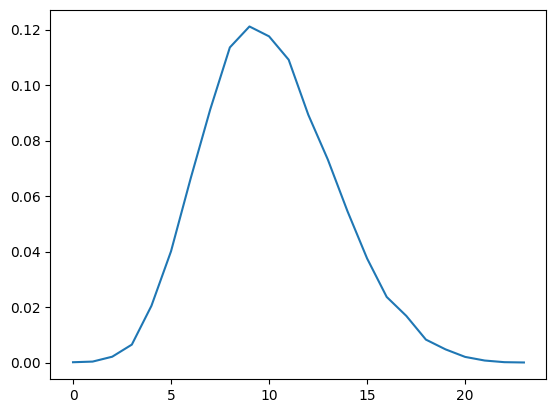

In [14]:
x_axis = list(range(len(l)))
y_axis = l
plt.plot(x_axis, y_axis)
plt.show()

## Ejercicio 2

In [15]:
BUFFER_SIZE = 100
SIM_TIME = 100

De esta manera cada maquina es un proceso y desp hay otro proceso que se encarga de llenar las lista con requests para que cada maquina vaya desencolando 
y procesando requests

In [16]:
class Machine:
    def __init__(self,id):
        self.working_time = 0
        self.requests_taken = 0
        self.id = id
    
    def process_request(self, request):
        self.requests_taken += 1
        self.working_time += request


In [42]:
class Request:
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time
        self.time_at_buffer = 0
        
    


In [65]:
"""
Con esta implementacion, las maquinas chequean que haya requests en la cola cada 1 seg. Osea, que si la cola estaa vacia, la maquina cada 1 seg va a 
chequear si llego un nuevo mensaje. Ver con los chicos si estan de acuerdo con esto (o tamb preguntar al de la practica). Porque otro caso que CREO que se puede
hacer es que apenas llegue un request, la maquina ya sepa y lo empieze a procesar all instante.
Tambien ver que onda el arrribo de mensajes, estan llegando cada mucho tiempo y los procesa re rapido entonces la cola siempre esta vacia
"""
def request_generator(env, requests_center, requests_buffer, seed):
    """Las solicitudes llegan siguiendo un proceso Poisson con una frecuencia media de 10
    por minuto. Por ende el tiempo entre 2 solicitudes consecutivas seguira una distribucion
    Exponencial de paremtro 10."""
    #exponential_gen = Exp_generator(seed, 1/6) # We turn the 10 minutes into seconds TO-DO: VER QUUE CON NUESTRO GEN ME DA NUMERO NEGATIVOS
    #exponential_gen.rand()
    #exponential_gen.rand() 
    
    print("Requests start to arrive")
    for i in itertools.count():
        #time_for_next_request = exponential_gen.rand()
        time_for_next_request = np.random.exponential(6) # El parametro en esta lib tiene que ser b=1/lambda
        
        print(f"The next request will arrive in {time_for_next_request}, we are at {env.now}")
        yield env.timeout(time_for_next_request)
        with requests_center.request() as req:
            yield req
            if requests_buffer.level == BUFFER_SIZE:
                print(f"The buffer is full and cannot accept more requests. This requests has been dropped at time {env.now}")
            else:
                print(f"A request arrived and was buffered at time {env.now}")
                yield requests_buffer.put(1)
    print("Requests will stop to arrive")


In [95]:
def processing_machine(env, requests_center, requests_buffer, seed, machine):
    #exponential_gen = Exp_generator(seed, 10) TO-DO: VER QUE CON NUESTRO GEN ME DA NUMERO NEGATIVOS
    print(f"The machine {machine.id} starts.")
    while True:
        
        time_to_process = 1
        request_processed = False
        print(f"Machine {machine.id} will try to process a request at {env.now}")
        with requests_center.request() as req:
            yield req
            
            if requests_buffer.level != 0:
                print(f"A request is starting to be processed by machine {machine.id} at {env.now}")
                yield requests_buffer.get(1)
                print(f"La cantidad de requests en el buffer es {requests_buffer.level}")
                #time_to_process = exponential_gen.rand()
                time_to_process = np.random.exponential(10)
                machine.process_request(time_to_process)
                print(f"Machine {machine.id} will finish at {time_to_process + env.now}")
                request_processed = True
                
        # If there are no requests to process in the buffer, the timeout is of 0 seconds.
        yield env.timeout(time_to_process)
        if request_processed:
            
            print(f"Machine {machine.id} has finished processing the request at {env.now}")

In [101]:
def buffer_stats(env, buffer, amount):
    while True:
        amount.append(buffer.level)
        yield env.timeout(1)

podemos usar nuestro generador, ronda cantidad de llegadas 11/12 en el primer minuto (empiricamente), varias veces se pasa y muy pocas veces de menos, el otro es mas uniforme, puede dar 8 o 13.  
voy a dejar el otro por ahora

In [102]:
env = simpy.Environment()
init = env.now
requests_center = simpy.Resource(env, 1)
requests_buffer = simpy.Container(env, BUFFER_SIZE, init=0)
env.process(request_generator(env, requests_center, requests_buffer, int(time.time())))

amount = []
machine_1 = Machine(1)
machine_2 = Machine(2)
env.process(buffer_stats(env, requests_buffer, amount))
env.process(processing_machine(env, requests_center, requests_buffer, int(time.time()), machine_1))
#env.process(processing_machine(env, requests_center, requests_buffer, int(time.time()), machine_2,amount))

env.run(until=SIM_TIME)

end = env.now

Requests start to arrive
The next request will arrive in 39.3161420619077, we are at 0
The machine 1 starts.
Machine 1 will try to process a request at 0
Machine 1 will try to process a request at 1
Machine 1 will try to process a request at 2
Machine 1 will try to process a request at 3
Machine 1 will try to process a request at 4
Machine 1 will try to process a request at 5
Machine 1 will try to process a request at 6
Machine 1 will try to process a request at 7
Machine 1 will try to process a request at 8
Machine 1 will try to process a request at 9
Machine 1 will try to process a request at 10
Machine 1 will try to process a request at 11
Machine 1 will try to process a request at 12
Machine 1 will try to process a request at 13
Machine 1 will try to process a request at 14
Machine 1 will try to process a request at 15
Machine 1 will try to process a request at 16
Machine 1 will try to process a request at 17
Machine 1 will try to process a request at 18
Machine 1 will try to proce

Ocupation factor con una maquina

In [78]:
program_time = end - init
ocupation_factor = machine_1.working_time/program_time
print(f"ocupation_factor: {ocupation_factor}")

ocupation_factor: 0.9772456526187071


Ocupation factor con dos maquinas

In [79]:
ocupation_factor = (machine_1.working_time + machine_2.working_time)/(program_time*2)
print(f"ocupation_factor: {ocupation_factor}")

ocupation_factor: 0.48862282630935355


Cantidad media de elementos en el buffer: a cada segundo mido la cantidad de elementos en el buffer, luego divido la suma por la cantidad total de mediciones

In [105]:
cant = 0
for i in amount:
    cant += i

cant = cant/len(amount)
print(f"cantidad media de elementos en el buffer: {cant}")  

cantidad media de elementos en el buffer: 1.89


## EJERCICIO 3

In [23]:
random.seed(22)

env = simpy.Environment()
processing_center = simpy.Resource(env, 2)

env.process(gas_station_control(env, fuel_pump))
env.process(car_generator(env, gas_station, fuel_pump))

NameError: name 'gas_station_control' is not defined

In [48]:
import simpy

class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age

# Create a SimPy environment
env = simpy.Environment()

# Create a container
people_container = simpy.Container(env, init=0)

# Create instances of the class
person1 = Person("Alice", 25)
person2 = Person("Bob", 30)

# Store instances in the container
people_container.put(person1)
people_container.put(person2)

# Retrieve instances from the container
while people_container.level > 0:
    person = people_container.get()
    print(person.name)

# Output: "Alice" followed by "Bob"

TypeError: '<=' not supported between instances of 'Person' and 'int'